IMPORTS

In [58]:
import pandas as pd
import sklearn
import scipy
import sklearn.ensemble as forest
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
import sklearn.gaussian_process as kriging
import seaborn as sns
from tensorflow import keras
from sklearn import preprocessing
from sklearn.pipeline import Pipeline, TransformerMixin,FeatureUnion
from sklearn.preprocessing import *
from feature_engine import wrappers
from sklearn.compose import ColumnTransformer
from sklearn import model_selection
from sklearn.gaussian_process import GaussianProcessRegressor
from feature_engine.creation import MathFeatures,RelativeFeatures
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV


In [59]:
from tensorflow import keras
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.gaussian_process.kernels import RBF


In [84]:
class Regressor:
    def __init__(self):
        # self.n_estimators=n_estimators
        self.random_state=5
        self.models=self._define_model()
        self.models_names=list(self._define_model().keys())
        self.params_=self._models_params()
        pass

    def _models_params(self):
        param_dict={
            
            'RandomForestRegressor':{
                    
                'bootstrap': [True, False],
                'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                # 'max_features': ['1.0', 'sqrt'],
                'min_samples_leaf': [1, 2, 4],
                'min_samples_split': [2, 5, 10],
                'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],},
       
         
            'GradientBoostingRegressor':{
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.1, 0.5],
                'max_depth': [3, 5, 7],
                'subsample': [0.8, 1.0],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2],
                # 'max_features': ['sqrt', 'log2']
            },
            

            'AdaBoostRegressor':{
            
                'n_estimators': [50, 100, 200],  # Number of estimators (weak learners)
                'learning_rate': [0.1, 0.5, 1.0],  # Learning rate
                'loss': ['linear', 'square', 'exponential']  # Loss function to use
                
                },

           'GaussianProcessRegressor' :{
                'kernel': [1.0 * RBF(length_scale=1.0), 1.0 * RBF(length_scale=0.5)],  # Kernel function
                'alpha': [1e-10, 1e-5, 1e-2],  # Regularization parameter
                
            },

            'SVR': {
                'kernel': ['linear', 'poly', 'rbf'],  # Kernel function
                'C': [0.1, 1.0, 10.0],  # Regularization parameter
                'epsilon': [0.1, 0.01, 0.001],# Epsilon parameter for epsilon-insensitive loss
                
            },

            'XGBRFRegressor' : {
                'learning_rate': [0.1, 0.01, 0.001],  # Learning rate
                'max_depth': [3, 4, 5],  # Maximum depth of each tree
                'subsample': [0.8, 0.9, 1.0],  # Subsample ratio of the training instances
                'colsample_bytree': [0.8, 0.9, 1.0],  # Subsample ratio of columns when constructing each tree
                'reg_alpha': [0, 0.1, 0.5],  # L1 regularization term on weights
                'reg_lambda': [0, 0.1, 0.5],  # L2 regularization term on weights
                'gamma': [0, 0.1, 0.5],  # Minimum loss reduction required to make a further partition on a leaf node
            
                }
        }

        # return [random_forest_params,gradient_boosting_regressor_params,ada_boost_regressor_params,gaussian_process_paramns,svr_params,xgb_regressor_params]
        return param_dict

    def _define_model(self):

        models={
            'RandomForestRegressor': RandomForestRegressor(),
            'GradientBoostingRegressor': GradientBoostingRegressor(),
            'AdaBoostRegressor': AdaBoostRegressor(),
            'GaussianProcessRegressor': GaussianProcessRegressor(),
            'SVR':SVR(),
            'XGBRFRegressor':XGBRegressor()
        }
        
        return models
        



Classes

In [61]:
# class ColumnTransformer(TransformerMixin):
#     def __init__(self,cols):   
#         self.cols=cols

#     def transform(self,X):
#         Xcols=X[self.cols]
#         return Xcols
    
#     def fit(self,X,y=None):
#         return self


Tratamento Dos Dados

In [62]:
dfx=pd.DataFrame(pd.read_csv(filepath_or_buffer='DadosMetamodelagemX1.csv',delimiter=',',index_col=False,names=['ReactionTemperature','H2FlowRate','SplitsValues','RefluxRatio','ReactorVolume','FeedPressure','NANx']))
dfy=pd.DataFrame(pd.read_csv('DadosMetamodelagemY1.csv',names=['ISBL','CustoMateriaPrima','CustoUtilidades','Methanol','IsValid','IsConverged','StreamConvergeance','NANy']))
dft=pd.DataFrame.join(dfx,dfy)
dft.drop(dft.loc[dft['StreamConvergeance']==False].index,inplace=True)
dft.drop(columns=['NANx','NANy','IsValid','StreamConvergeance','IsConverged'],inplace=True)
dft.reset_index(inplace=True,drop=True)
TotalCost=pd.DataFrame({'TotalCost':(dft['ISBL']+dft['CustoUtilidades']+dft['CustoMateriaPrima'])})
dft=dft.join(TotalCost)
target=['TotalCost','Methanol','ISBL','CustoUtilidades','CustoMateriaPrima']
features=['ReactionTemperature','H2FlowRate','SplitsValues','RefluxRatio','ReactorVolume','FeedPressure']
x_train,x_test,y_train,y_test=model_selection.train_test_split(dft[features],dft[target],test_size=0.33)
train_test_data_list=[x_train,x_test,y_train,y_test]
for i in train_test_data_list:
    i.reset_index(inplace=True,drop=True)
df_train=x_train.join(y_train)
df_test=x_test.join(y_test)

HeatMap Das Correlações

Text(0.5, 1.0, 'TESTE')

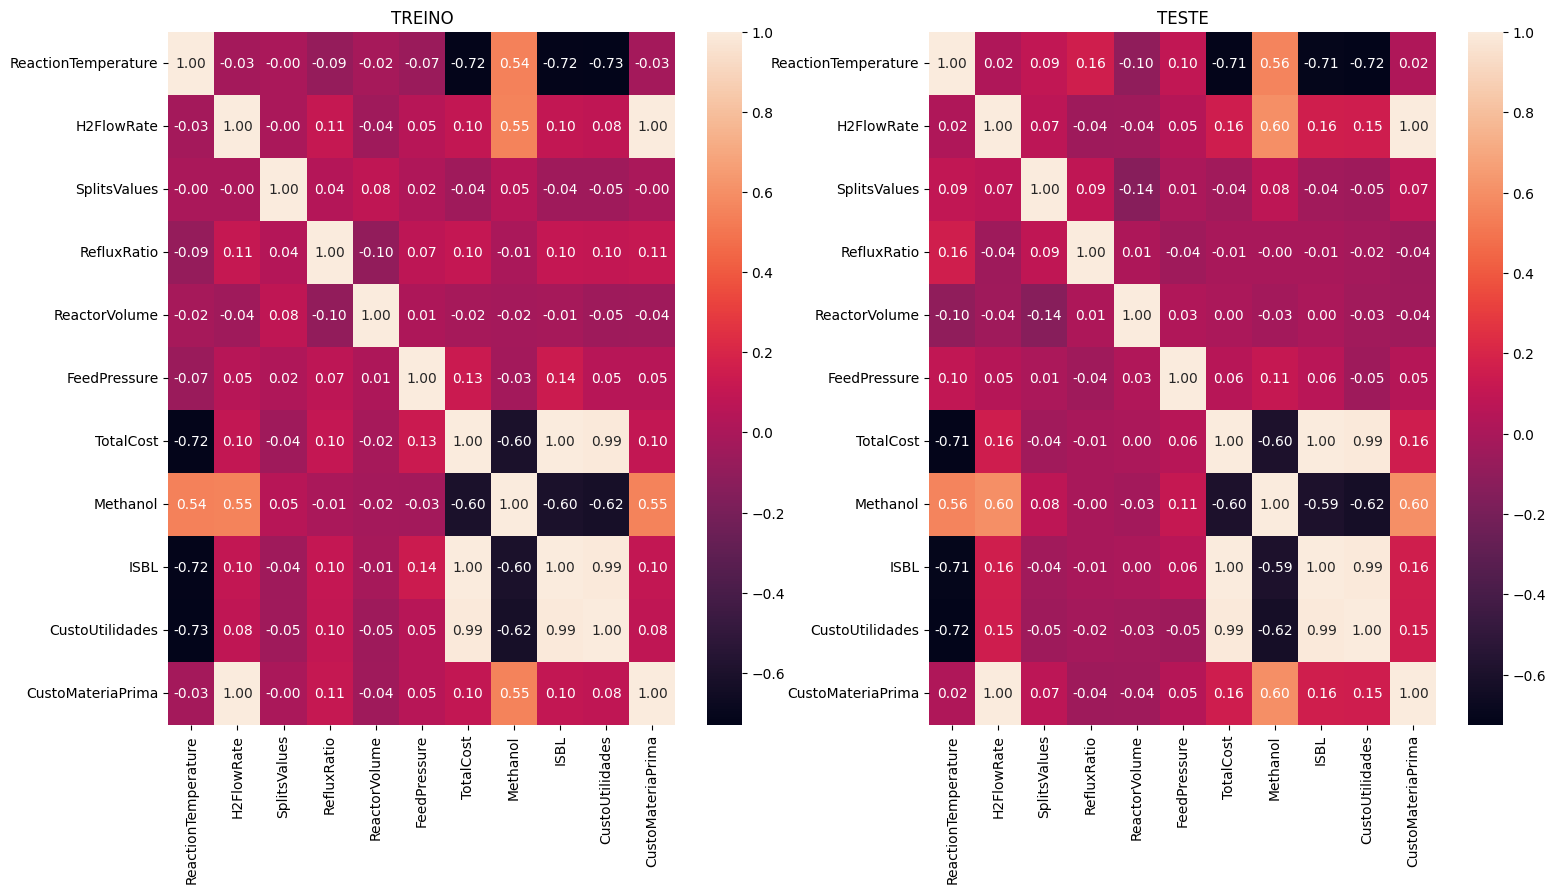

In [63]:

fig,axes=plt.subplots(1,2,figsize=(18,9))

sns.heatmap(df_train.corr(),annot=True,annot_kws={'size':'10'},fmt='.2f',ax=axes[0])
sns.heatmap(df_test.corr(),annot=True,annot_kws={'size':'10'},fmt='.2f',ax=axes[1])
axes[0].set_title('TREINO')
axes[1].set_title('TESTE')

ISBL , CustoUtilidades e CustoMateriaPrima são Targets redundantes, portanto TAC, Methanol e serão trabalhados

In [64]:
for i in [dft,df_train,df_test,y_train,y_test]:
    i.drop(columns=['ISBL','CustoUtilidades','CustoMateriaPrima'],inplace=True)

Text(0.5, 0.98, 'Teste')

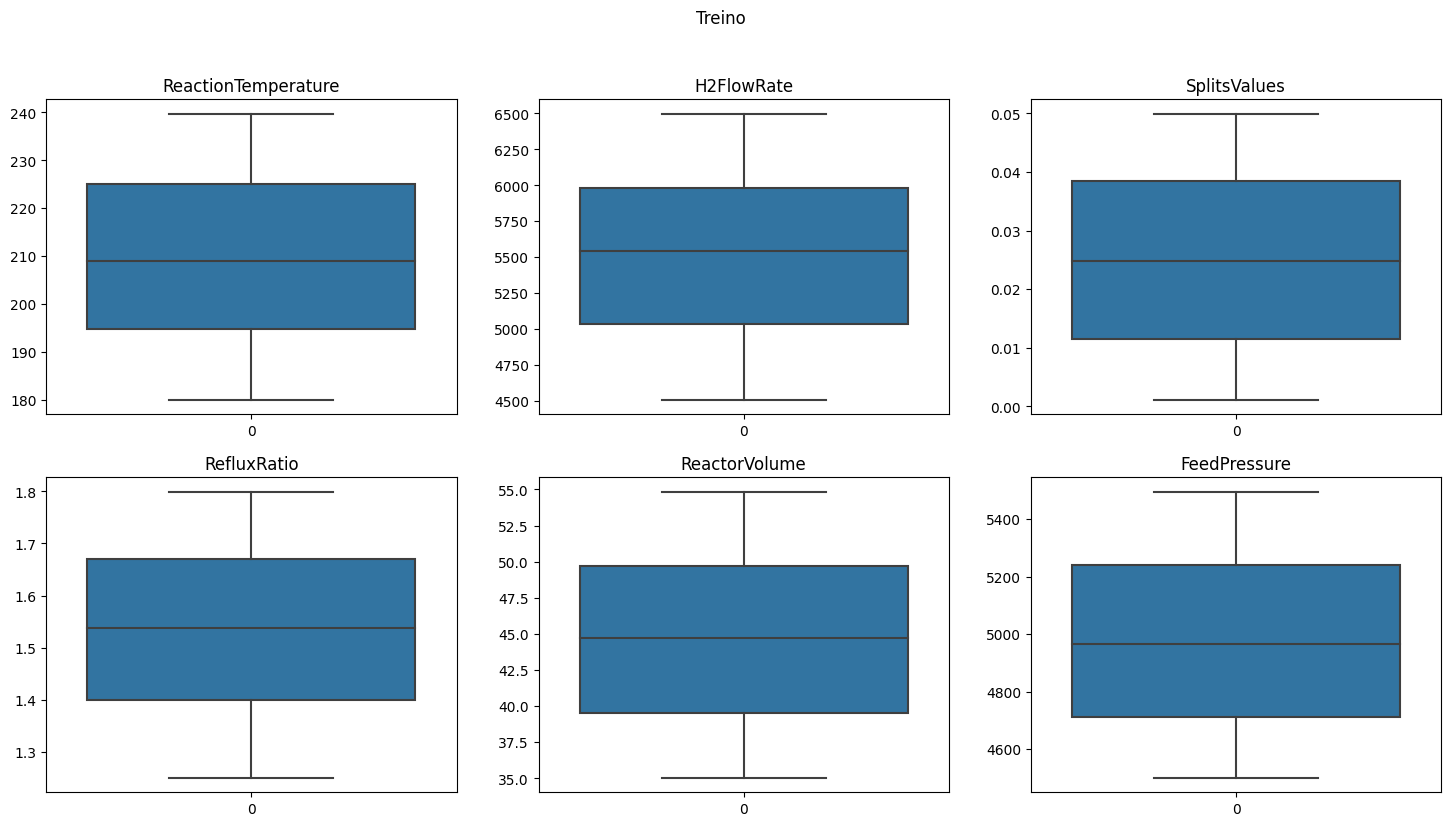

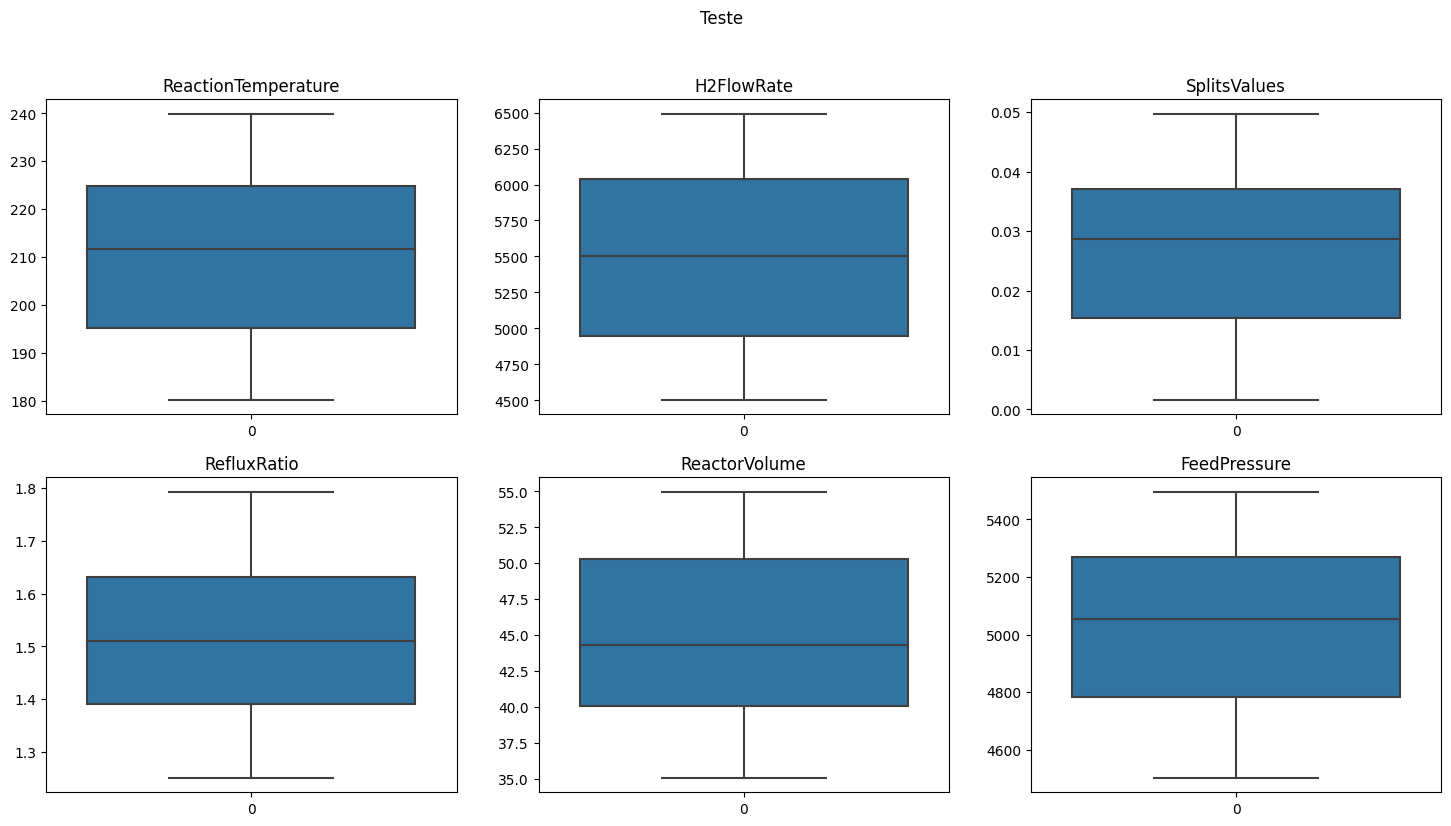

In [65]:

target=['TotalCost','Methanol']
fig,axes=plt.subplots(2,3,figsize=(18,9))
axesf=axes.flatten()
for i, columns in enumerate(df_train[features].columns.to_list()):
    ax=axesf[i]
    ax.set_title(columns)
    sns.boxplot(df_train[columns],ax=ax)

fig.suptitle('Treino')


fig,axes=plt.subplots(2,3,figsize=(18,9))
axesf=axes.flatten()
for i, columns in enumerate(df_test[features].columns.to_list()):
    ax=axesf[i]
    ax.set_title(columns)
    sns.boxplot(df_test[columns],ax=ax)

fig.suptitle('Teste')


Text(0.5, 0.98, 'Teste')

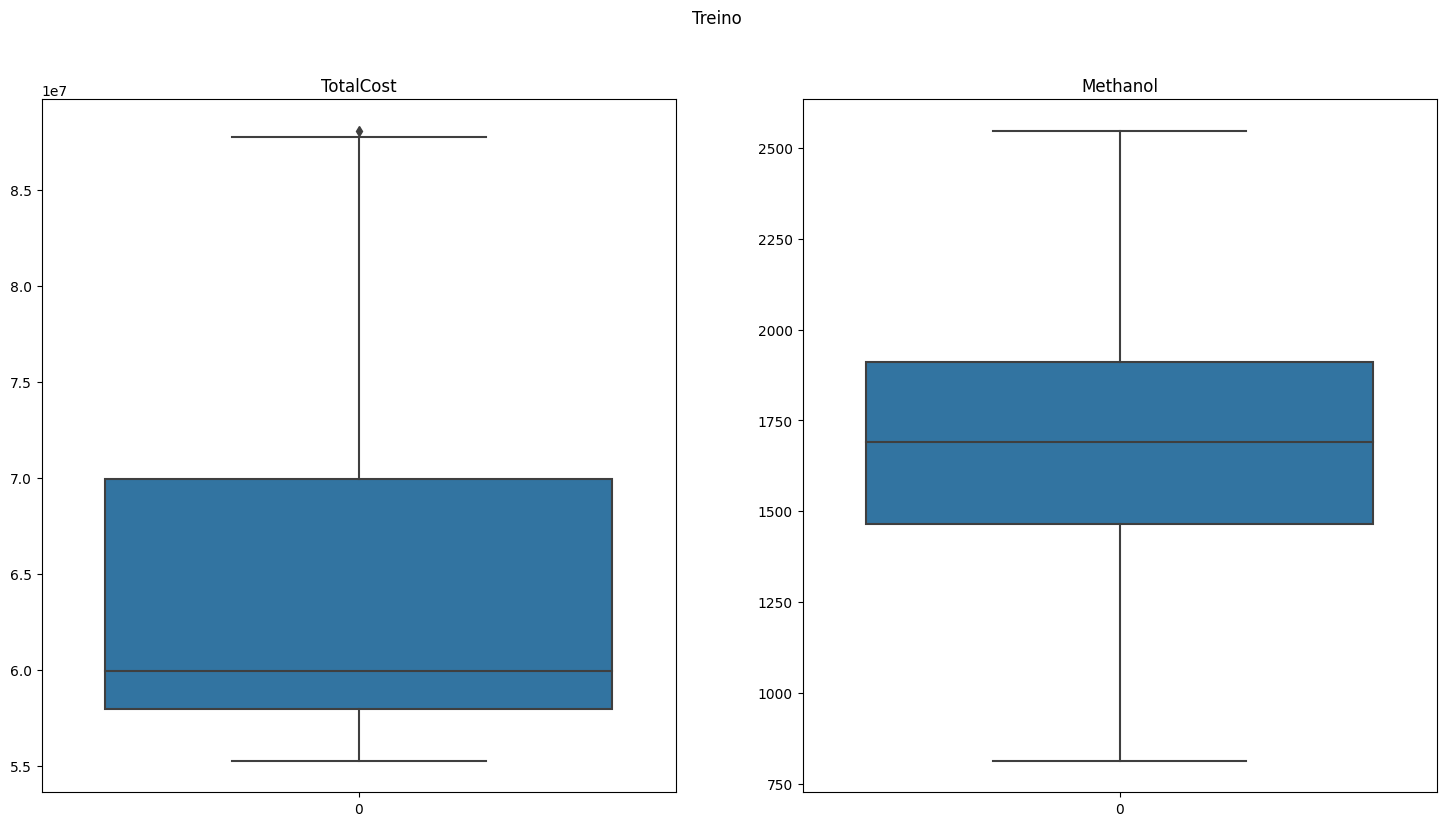

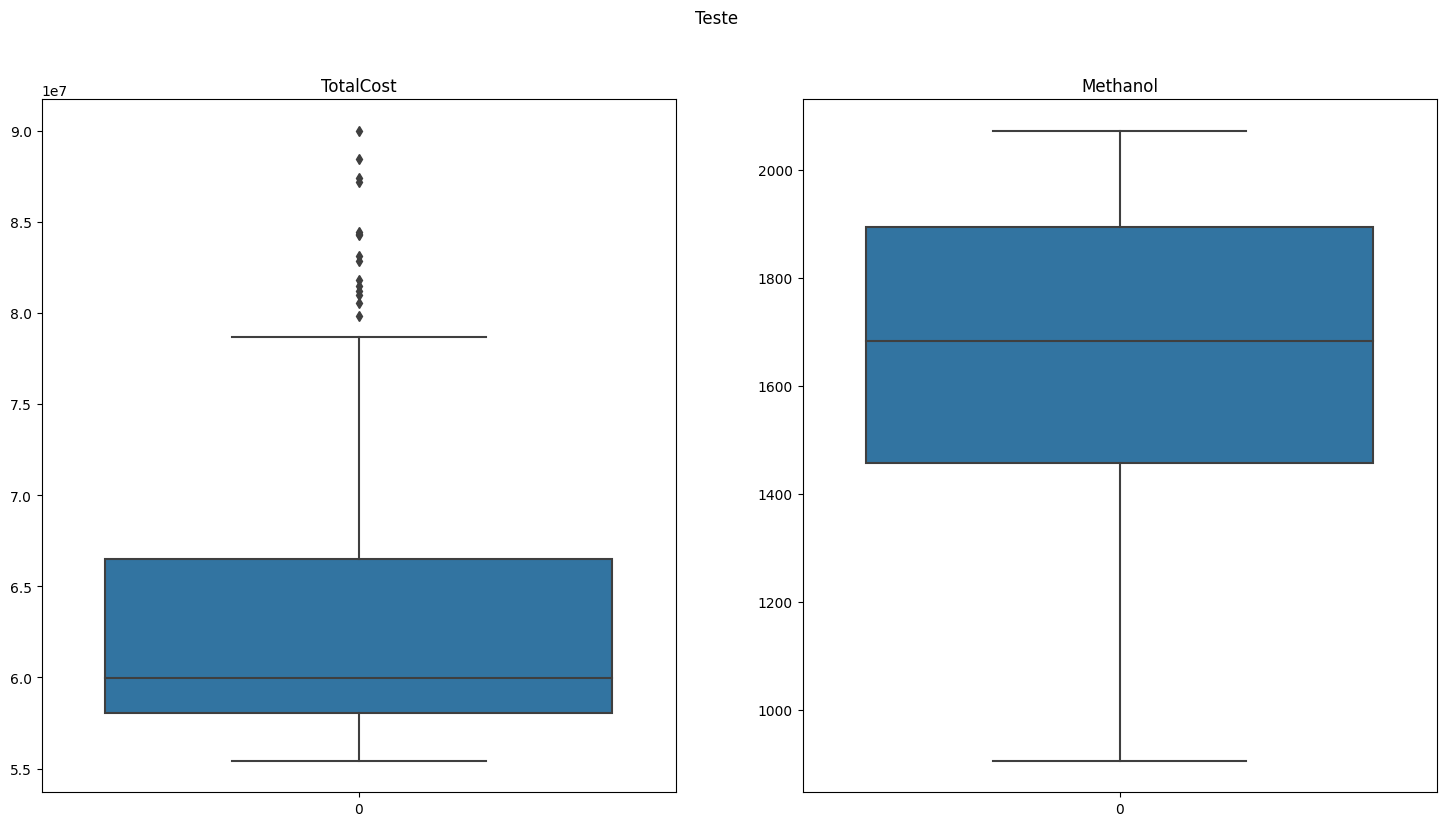

In [66]:

fig,axes=plt.subplots(1,2,figsize=(18,9))
axesf=axes.flatten()
for i, columns in enumerate(df_train[target].columns.to_list()):
    ax=axesf[i]
    ax.set_title(columns)
    sns.boxplot(df_train[columns],ax=ax)

fig.suptitle('Treino')


fig,axes=plt.subplots(1,2,figsize=(18,9))
axesf=axes.flatten()
for i, columns in enumerate(df_test[target].columns.to_list()):
    ax=axesf[i]
    ax.set_title(columns)
    sns.boxplot(df_test[columns],ax=ax)

fig.suptitle('Teste')

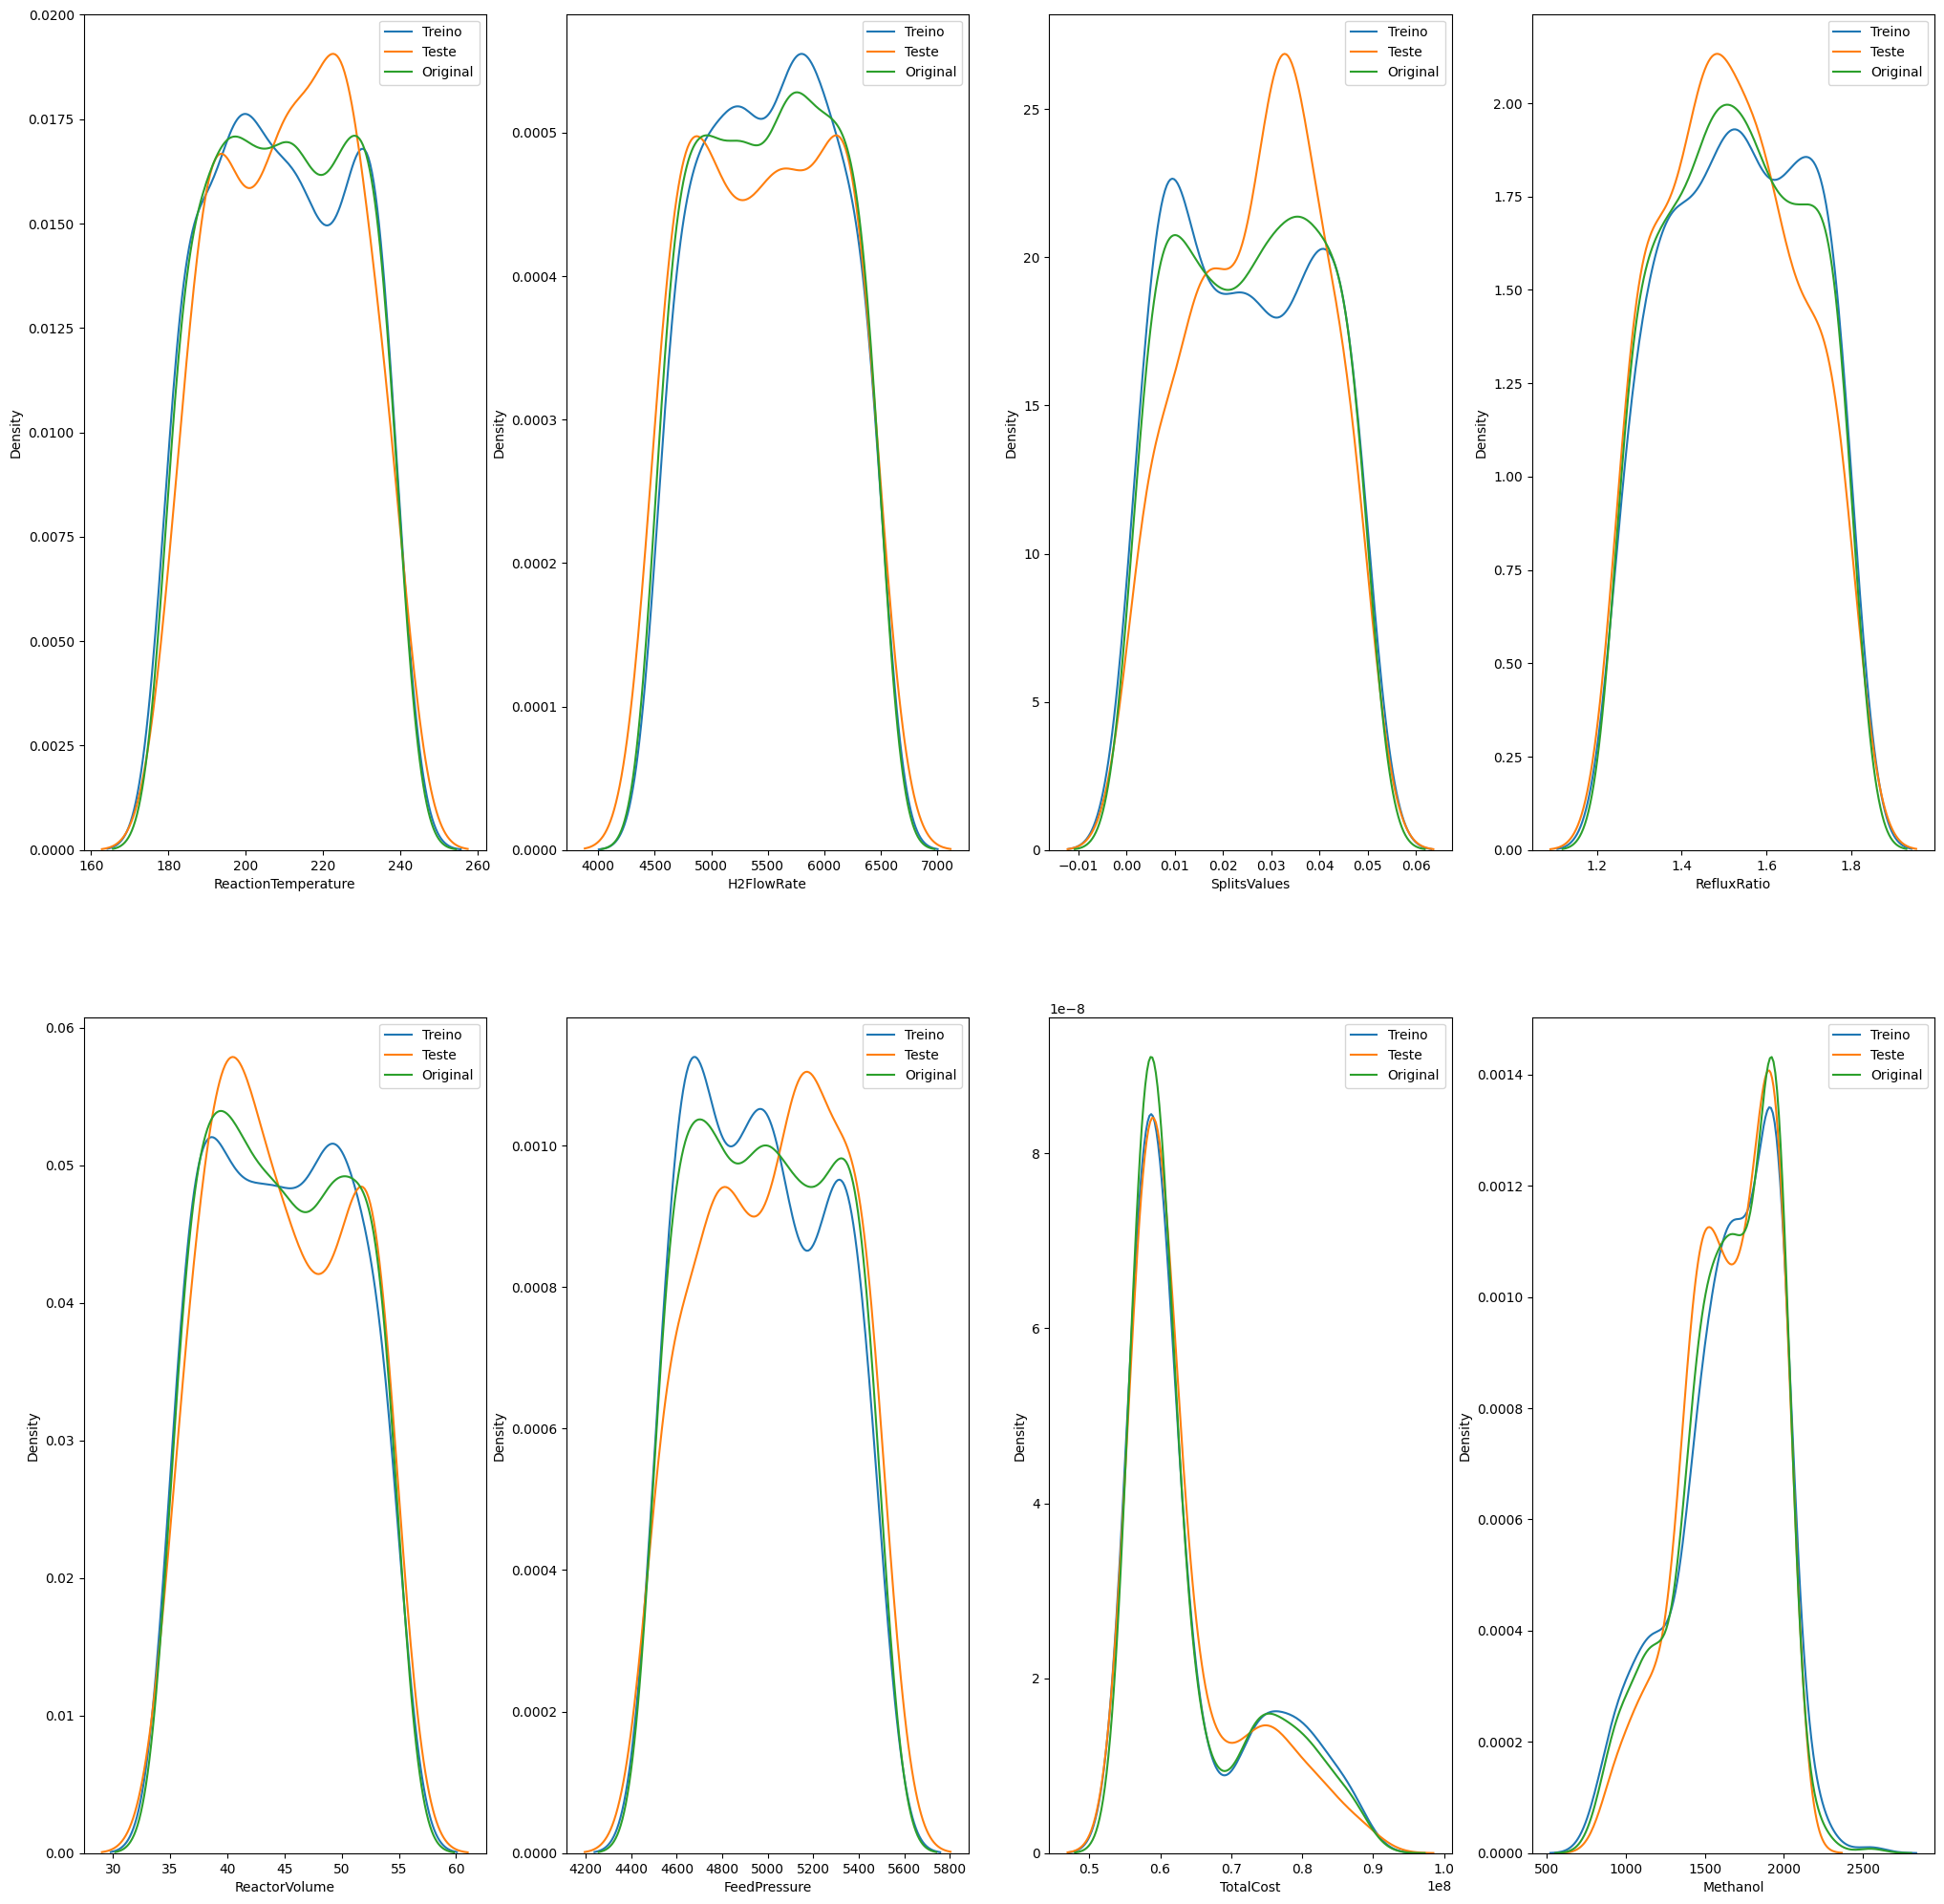

In [67]:

fig,axes=plt.subplots(2,4,figsize=(25,25))
axesf=axes.flatten()
for i, columns in enumerate(df_train.columns.to_list()):
    ax=axesf[i]
    sns.kdeplot(df_train[columns],ax=ax)
    sns.kdeplot(df_test[columns],ax=ax)
    sns.kdeplot(dft[columns],ax=ax)
    ax.legend(['Treino','Teste','Original'])
    
    
    

TAC e Methanol com OUTLIERS, tratamento de dados a serem aplicados:

Para modelos baseados em regressão é preferível que os targets possuam distribuição gaussiana e as features possuam a mesma escala

In [68]:
target_transformer=ColumnTransformer([('target_transformer',QuantileTransformer(),target)])
target_transformer.set_output(transform='pandas')
y_train=target_transformer.fit_transform(y_train)
y_test=target_transformer.transform(y_test)

feature_trans=Pipeline([('CreateFeatures',RelativeFeatures(variables=['FeedPressure','ReactionTemperature','H2FlowRate'],reference=['ReactorVolume'],func=['div'])),('StandardScaler',StandardScaler())])
feature_trans.set_output(transform='pandas')
x_train=feature_trans.fit_transform(x_train)
x_test=feature_trans.transform(x_test)

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (409). n_quantiles is set to n_samples.
  warnings.warn(


In [85]:
regressor=Regressor()
models=regressor.models
parameters = regressor._models_params()
best_params={}
scores={}
# scoring={'r2':metrics.make_scorer(metrics.r2_score),'neg_mean_squared_error':metrics.make_scorer(metrics.mean_squared_error)}

for name, model in models.items():
    gs=RandomizedSearchCV(estimator=model,param_distributions=parameters[name],cv=3,scoring='r2')
    gs.fit(x_train,y_train[y_train.columns[0]])
    scores.update({name:gs.best_score_})
    best_params.update({name:gs.best_params_})
    print('Modelo:{}\n score: {} \n Parametros:{}'.format(*[name,scores[name],best_params[name]]))


Modelo:RandomForestRegressor
 score: 0.7453464701831827 
 Parametros: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 100, 'bootstrap': True}
Modelo:GradientBoostingRegressor
 score: 0.7406021499266225 
 Parametros: {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.1}
Modelo:AdaBoostRegressor
 score: 0.7328931021917328 
 Parametros: {'n_estimators': 200, 'loss': 'square', 'learning_rate': 1.0}


c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Modelo:GaussianProcessRegressor
 score: 0.5812521724013795 
 Parametros: {'kernel': 1**2 * RBF(length_scale=1), 'alpha': 0.01}
Modelo:SVR
 score: 0.40130754518316286 
 Parametros: {'kernel': 'rbf', 'epsilon': 0.01, 'C': 10.0}
Modelo:XGBRFRegressor
 score: 0.6890191400041136 
 Parametros: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 1.0}


In [86]:
x_train

,ReactionTemperature,H2FlowRate,SplitsValues,RefluxRatio,ReactorVolume,FeedPressure,FeedPressure_div_ReactorVolume,ReactionTemperature_div_ReactorVolume,H2FlowRate_div_ReactorVolume
0,-1.658711,0.033455,-0.459889,0.004929,1.044745,0.288445,-0.834443,-1.624105,-0.784266
1,0.990659,1.511742,-0.125730,1.556852,-1.497475,1.386325,2.221412,2.047395,2.416633
2,-1.473946,0.342164,-1.617431,-1.213613,-1.556803,-0.839749,1.196544,0.509031,1.630238
3,-0.439412,-0.558376,1.201892,-0.491607,-0.740068,-1.090815,0.128634,0.302159,0.152417
4,1.358227,0.841272,-0.141756,0.501973,-0.250156,1.499647,0.731381,0.838018,0.607556
...,...,...,...,...,...,...,...,...,...
404,-0.793556,-0.757699,1.385173,-1.428677,-0.564446,0.069601,0.454060,-0.062535,-0.124935
405,1.584734,-0.289589,-0.868651,0.284464,-0.009906,1.521671,0.499810,0.731802,-0.267365
406,0.037914,0.252288,0.377016,-0.111089,0.388821,1.395779,0.083996,-0.391043,-0.242053
407,-1.623367,-1.150514,-0.410713,0.839169,-1.235725,0.134501,1.254763,0.074134,0.202551


In [81]:
y_train.columns[0]

'target_transformer__TotalCost'